## Import tweets using twitter API, clean data, do sentiment analsis and create a csv file to analyze the data in R

In [1]:
# Import all modules required

import tweepy
import datetime
import time
import pandas as pd
import numpy as np
import json
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


## Tweet Collection

In [46]:
# twitter api access codes

con_key = 'enter con_key'
con_secret = 'enter con_secret'
acc_token = 'enter acc_token'
acc_secret = 'enter acc_secret'

In [47]:
#Use tweepy.OAuthHandler to create an authentication using the given key and secret

auth = tweepy.OAuthHandler(consumer_key=con_key, consumer_secret=con_secret)
auth.set_access_token(acc_token, acc_secret)

#Connect to the Twitter API using the authentication
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify = True)



In [62]:
# getting tweets, use #moab and MOAB, filter out retweets, media and urls for date range 04/13/2017 to 04/15/2017
# append all the tweets to a list

tweet_list = []
for tweet in tweepy.Cursor(api.search, q="#%23moab -filter:retweets -filter:media -filter:urls" or 
                           "#%23MOAB -filter:retweets -filter:media -filter:urls" , 
                            since="2017-04-13",until="2017-04-15",lang="en").items(10000):
    
    tweet_list.append(tweet)


Rate limit reached. Sleeping for: 856
Rate limit reached. Sleeping for: 858
Rate limit reached. Sleeping for: 844
Rate limit reached. Sleeping for: 848


## Convert tweet data to json file and create a dataframe and save it to csv file with all the data required for analysis

In [63]:
# Convert the tweet list to json and save the file. Json data will be in a list tweet_data

tweet_data =[]
current_working_dir = "./"
log_tweets = current_working_dir  + str(time.time()) + '_tweet.txt'

with open(log_tweets, 'w') as outfile:
        for tweet in tweet_list:
            tweet_data.append(json.loads(json.dumps(tweet._json)))
            outfile.write(json.dumps(tweet._json))
            outfile.write("\n")

In [64]:
#create a data frame with the data required for analysis

tweet_df = pd.DataFrame()

tweet_df['created_at'] = list(map(lambda tweet: time.strftime('%m-%d-%Y', 
                                                time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')), tweet_data)) 

tweet_df['user'] = list(map(lambda tweet: tweet['user']['screen_name'], tweet_data))

tweet_df['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweet_data))

tweet_df['text'] = list(map(lambda tweet: tweet['text'], tweet_data))

tweet_df['clean_text'] = tweet_df['text'].map(lambda x: re.sub(r'\W+', ' ', x))

tweet_df['user_loc'] = list(map(lambda tweet: tweet['user']['location'] if tweet['place'] != None else None, tweet_data))

tweet_df['country'] = list(map(lambda tweet: tweet['place']['country_code'] if tweet['place'] != None else None, tweet_data))

tweet_df['user_followers_count'] = list(map(lambda tweet: tweet['user']['followers_count'], tweet_data))

In [68]:
#save the dataframe to a csv file

tweet_df.to_csv("tweets_data.csv", encoding='utf-8', index=False)

In [4]:
#load the csv file

moab_df = pd.read_csv("C:/Users/Ravi/Documents/Ravi/DS710/ds710spring2017_FinalProject/tweets_data.csv")
moab_df.head()

,created_at,user,retweet_count,text,clean_text,user_loc,country,user_followers_count
0,04-14-2017,007Mugambo,0.0,So the world's richest country bombed one of p...,So the world s richest country bombed one of p...,NaN,NaN,388.0
1,04-14-2017,CHamiltonBooks,0.0,"I just heard my friend say ""The only good thin...",I just heard my friend say The only good thing...,NaN,NaN,7914.0
2,04-14-2017,BlackBerry_Mama,0.0,This is what the Kingdom of #Moab is known for...,This is what the Kingdom of Moab is known for ...,"Manhattan, NY",US,3355.0
3,04-14-2017,Cheloga2,3.0,You Could Get 68 #HillaryClinton Speeches For ...,You Could Get 68 HillaryClinton Speeches For T...,NaN,NaN,5772.0
4,04-14-2017,LoganSFrawley,0.0,"Some truth, I'm FAR from supporting everything...",Some truth I m FAR from supporting everything ...,NaN,NaN,1016.0


## sentiment analysis using textblob module. In this module ploarity < 0 is negative,                     polarity = 0 is neutral and polarity > 0 is positve. Add columns for polarity value and sentiment for each tweet to existing table.

In [260]:
# using textblob to calulate the sentiment value. Create a function to get the sentiment value

def sentiment_value(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None


In [ ]:
# create a col with sentiment value for each tweet

moab_df['sentiment_polarity'] = moab_df['clean_text'].apply(sentiment_value)

In [261]:
# create a funtion to label the tweet as positve/negative/neutral based on the sentiment value

def sentiment(value):
    if value >0:
        return "Positive"
    elif value == 0:
        return "neutral"
    else:
        return "negative"

In [263]:
#create a column with seniment type for each tweet

moab_df['sentiment'] = moab_df['sentiment_polarity'].apply(sentiment)

## For tweets with country code, create column which has USA for tweets orginated in US and rest of the countries as Rest of the world.

In [291]:
# create a function to return USA for tweets from US and Rest of the world for all other countries
def country_code(country):
    if country == "":
        return ""
    elif country == "US":
        return "USA"
    else:
        return "Rest of the World"

In [292]:
# create a column to label tweets with location information as US or rest of world for all other countries
moab_df['region'] = moab_df['country'].apply(country_code)

In [293]:
moab_df.head()

,created_at,user,retweet_count,text,clean_text,user_loc,country,user_followers_count,sentiment_polarity,sentiment,region
0,04-14-2017,007Mugambo,0.0,So the world's richest country bombed one of p...,So the world s richest country bombed one of p...,,,388,0,neutral,
1,04-14-2017,CHamiltonBooks,0.0,"I just heard my friend say ""The only good thin...",I just heard my friend say The only good thing...,,,7914,0.35,Positive,
2,04-14-2017,BlackBerry_Mama,0.0,This is what the Kingdom of #Moab is known for...,This is what the Kingdom of Moab is known for ...,"Manhattan, NY",US,3355,0,neutral,USA
3,04-14-2017,Cheloga2,3.0,You Could Get 68 #HillaryClinton Speeches For ...,You Could Get 68 HillaryClinton Speeches For T...,,,5772,0,neutral,
4,04-14-2017,LoganSFrawley,0.0,"Some truth, I'm FAR from supporting everything...",Some truth I m FAR from supporting everything ...,,,1016,0.247619,Positive,


## Clean data and export the data to csv file to analyze in R

In [294]:
#Remove rows where there is no text in the tweet col

moab_df = moab_df[moab_df.text != ""]

In [295]:
#since R does not reconize NaN convert all NaN into blanks

moab_df.fillna("", inplace=True)

In [297]:
# load the clean data which has sentiment values into csv. We will use this file to do analysis in R
#load the data sepeartely to another file with country data

moab_df.to_csv("sentiment_data.csv", encoding='utf-8', index=False)

## Create an WordCloud with most common words used

In [371]:
# create wordcloud from all the tweets to see what are the most used words
# join tweets to a single string

words = ' '.join(moab_df['text'])

In [372]:
# remove URLs, RTs, and twitter handles to get clean text in wordcloud
clean_words = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])


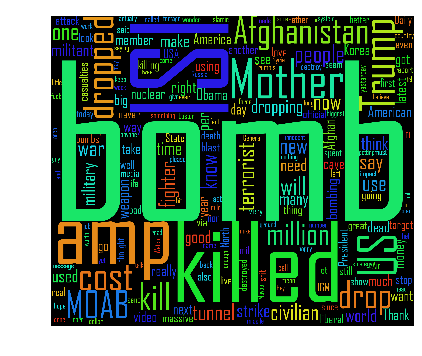

In [380]:
# create word cloud
wordcloud = WordCloud(
                      font_path='C:/Users/Ravi/fonts/AGENCYR.ttf',
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=2800,
                      height=2400
                     ).generate(clean_words)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()